In [2]:
!pip install mlflow

     --------------------------------------- 17.7/17.7 MB 28.5 MB/s eta 0:00:00
     ---------------------------------------- 184.3/184.3 kB ? eta 0:00:00
     ---------------------------------------- 82.7/82.7 kB ? eta 0:00:00
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
     ---------------------------------------- 57.7/57.7 kB ? eta 0:00:00
     --------------------------------------- 20.6/20.6 MB 31.2 MB/s eta 0:00:00
     ---------------------------------------- 212.9/212.9 kB ? eta 0:00:00
     ------------------------------------- 420.6/420.6 kB 25.7 MB/s eta 0:00:00
     -------------------------------------- 147.5/147.5 kB 9.2 MB/s eta 0:00:00
     ---------------------------------------- 41.2/41.2 kB ? eta 0:00:00
     ---------------------------------------- 78.7/78.7 kB ? eta 0:00:00
     -------------------------------------- 151.7/151.7 kB 9.4 MB/s eta 0:00:00
     ---------------------------------------- 62.7/62.7 

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import re
import nltk
import mlflow
import pickle
import csv

In [2]:
mental_health_tweets = pd.read_csv('https://raw.githubusercontent.com/thalia-huynh/predicting-depression-using-nlp/main/Mental-Health-Twitter.csv', index_col=[0])
sentiment_tweets = pd.read_csv('https://raw.githubusercontent.com/Jsujanchowdary/predicting-depression-using-nlp/main/sentiment_tweets3.csv', index_col=[0])

In [3]:
mental_health_tweets.info

<bound method DataFrame.info of                   post_id                    post_created  \
0      637894677824413696  Sun Aug 30 07:48:37 +0000 2015   
1      637890384576778240  Sun Aug 30 07:31:33 +0000 2015   
2      637749345908051968  Sat Aug 29 22:11:07 +0000 2015   
3      637696421077123073  Sat Aug 29 18:40:49 +0000 2015   
4      637696327485366272  Sat Aug 29 18:40:26 +0000 2015   
...                   ...                             ...   
19995  819336825231773698  Thu Jan 12 00:14:56 +0000 2017   
19996  819334654260080640  Thu Jan 12 00:06:18 +0000 2017   
19997  819334503042871297  Thu Jan 12 00:05:42 +0000 2017   
19998  819334419374899200  Thu Jan 12 00:05:22 +0000 2017   
19999  819334270825197568  Thu Jan 12 00:04:47 +0000 2017   

                                               post_text     user_id  \
0      It's just over 2 years since I was diagnosed w...  1013187241   
1      It's Sunday, I need a break, so I'm planning t...  1013187241   
2      Awake but ti

In [4]:
sentiment_tweets.info

<bound method DataFrame.info of                                        message to examine  \
Index                                                       
106     just had a real good moment. i missssssssss hi...   
217            is reading manga  http://plurk.com/p/mzp1e   
220     @comeagainjen http://twitpic.com/2y2lx - http:...   
288     @lapcat Need to send 'em to my accountant tomo...   
540         ADD ME ON MYSPACE!!!  myspace.com/LookThunder   
...                                                   ...   
802309  No Depression by G Herbo is my mood from now o...   
802310  What do you do when depression succumbs the br...   
802311  Ketamine Nasal Spray Shows Promise Against Dep...   
802312  dont mistake a bad day with depression! everyo...   
802313                                                  0   

        label (depression result)  
Index                              
106                             0  
217                             0  
220                           

In [5]:
mental_health_tweets.isnull().all()

post_id         False
post_created    False
post_text       False
user_id         False
followers       False
friends         False
favourites      False
statuses        False
retweets        False
label           False
dtype: bool

In [6]:
sentiment_tweets.isnull().all()

message to examine           False
label (depression result)    False
dtype: bool

In [7]:
# specify columns to keep for d2
mental_health_tweets = mental_health_tweets[['post_text', 'label']]

# confirm columns kept are the correct ones we want
mental_health_tweets.head()

,post_text,label
0,It's just over 2 years since I was diagnosed w...,1
1,"It's Sunday, I need a break, so I'm planning t...",1
2,Awake but tired. I need to sleep but my brain ...,1
3,RT @SewHQ: #Retro bears make perfect gifts and...,1
4,It’s hard to say whether packing lists are mak...,1


In [8]:
# standardize column names for df2
sentiment_tweets.columns= ['post_text', 'label']

[Text(0.5, 1.0, 'label counts for sentiment_tweets')]

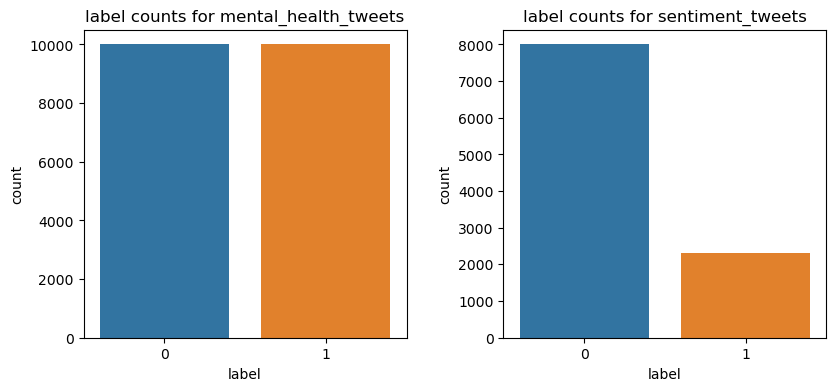

In [9]:
# set up space for figure
fig = plt.figure(figsize=(15,4))
fig.subplots_adjust(hspace=0.3, wspace=0.3)

# counts for mental_health_tweets
ax1 = fig.add_subplot(1,3,2)
sns.countplot(x='label', data=mental_health_tweets)
ax1.set(title="label counts for mental_health_tweets")

# counts for sentiment_tweets
ax2 = fig.add_subplot(1,3,3)
sns.countplot(x='label', data=sentiment_tweets)
ax2.set(title="label counts for sentiment_tweets")

In [10]:
# look at actual numbers
mental_health_tweets['label'].value_counts()
sentiment_tweets['label'].value_counts()

0    8000
1    2314
Name: label, dtype: int64

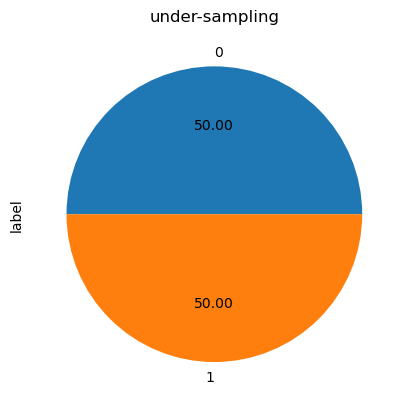

In [11]:
from imblearn.under_sampling import RandomUnderSampler
X = sentiment_tweets.drop(['label'], axis=1)
y = sentiment_tweets['label']

rus = RandomUnderSampler(sampling_strategy='not minority')
X_res, y_res = rus.fit_resample(X, y)

# visualize proportion of labels after balancing
ax = y_res.value_counts().plot.pie(autopct='%.2f')
_ = ax.set_title("under-sampling")

In [12]:
# class distribution
y_res.value_counts()

0    2314
1    2314
Name: label, dtype: int64

In [13]:
# combine columns for d3
df2 = pd.concat([X_res, y_res], axis='columns')

# confirm successful concatenation
df2.head()

# confirm balanced data
df2['label'].value_counts()

0    2314
1    2314
Name: label, dtype: int64

In [14]:
tweets = pd.concat([mental_health_tweets, sentiment_tweets])

# confirm change
tweets.shape

(30314, 2)

In [15]:
# split words in 'post-text' and count
tweets['word_count'] = tweets['post_text'].apply(lambda x: len(str(x).split()))
tweets.head()

,post_text,label,word_count
0,It's just over 2 years since I was diagnosed w...,1,26
1,"It's Sunday, I need a break, so I'm planning t...",1,19
2,Awake but tired. I need to sleep but my brain ...,1,13
3,RT @SewHQ: #Retro bears make perfect gifts and...,1,23
4,It’s hard to say whether packing lists are mak...,1,21


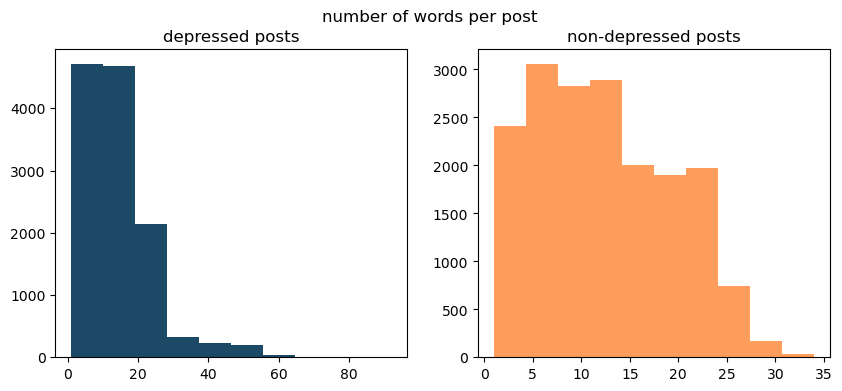

In [16]:
# plot number of words in 'depressed' and 'non-depressed' posts
fig,(ax1, ax2) = plt.subplots(1, 2, figsize = (10, 4))

dep_words = tweets[tweets['label'] == 1]['word_count']
ax1.hist(dep_words,color='#1c4966')
ax1.set_title('depressed posts')

non_dep_words = tweets[tweets['label'] == 0]['word_count']
ax2.hist(non_dep_words, color = '#ff9d5c')
ax2.set_title('non-depressed posts')

fig.suptitle('number of words per post')
plt.show()

In [17]:
print('The minimum number of words in non-depressed posts is: ', non_dep_words.min())
print('The maximum number of words in non-depressed posts is: ', non_dep_words.max())
print('___________________________________________________________')
print('The minimum number of words in depressed posts is: ', dep_words.min())
print('The maximum number of words in non-depressed posts is: ', dep_words.max())
print('___________________________________________________________')
print('The average number of words in non-depressed posts is: ', round(non_dep_words.mean()))
print('The average number of words in depressed posts is: ', round(dep_words.mean()))

The minimum number of words in non-depressed posts is:  1
The maximum number of words in non-depressed posts is:  34
___________________________________________________________
The minimum number of words in depressed posts is:  1
The maximum number of words in non-depressed posts is:  92
___________________________________________________________
The average number of words in non-depressed posts is:  12
The average number of words in depressed posts is:  15


In [18]:
from sklearn.model_selection import train_test_split

# split into training and testing site with 20% of rows going to testing and 80% going to training
# random state of 10 ensures reproducibility
X_train, X_test, y_train, y_test = train_test_split(tweets['post_text'], tweets['label'], test_size = 0.2, random_state = 10)

print(f"Number of training: {X_train.shape[0]}")
print(f"Number of testing: {X_test.shape[0]}")

Number of training: 24251
Number of testing: 6063


In [19]:
from bs4 import BeautifulSoup

# create stepwise cleaning function
def preprocess(text):
    
    # lowercase text
    text = text.lower()
    
    # strip all excess white space
    text = text.strip()
    
    # strip HTML tags
    text = BeautifulSoup(text, 'html.parser').get_text(separator = ' ')
    
    # remove retweets
    text = re.sub('rt @[\w_]+:','', text)
    
    # remove hyperlinks
    text = re.sub(r'http\S+','', text)
    
    # remove escape sequences
    text = re.sub(r'\n','', text)
    
    # remove punctuations
    text = re.sub(r'[^A-Za-z0-9]+', ' ', text)
    
    return text

In [20]:
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

stop_words = set(stopwords.words('english'))

# remove stopwords
def remove_stopwords(text):
    word_tokens = word_tokenize(text)
    text_no_stop = [word for word in word_tokens if word not in stop_words]
    return text_no_stop

In [21]:
from nltk.stem import WordNetLemmatizer

# lemmatize
def lemmatize_text(list_of_tokenized_words):
    lemmatizer = WordNetLemmatizer()
    lemmatized = [lemmatizer.lemmatize(token) for token in list_of_tokenized_words]
    return lemmatized

In [22]:
# put it all together
def final_preprocess(text):
    return preprocess(remove_stopwords(lemmatize_text(text)))
    
# pre-process training data
X_train_clean = [preprocess(text) for text in X_train]

D:\nodedynamic\anaconda\lib\site-packages\bs4\__init__.py:435: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  warnings.warn(


In [23]:
from sklearn.feature_extraction.text import TfidfVectorizer

# initialize
tfidf_vectorizer = TfidfVectorizer(min_df = 0.0003)
tfidf_vec_matrix = tfidf_vectorizer.fit_transform(X_train_clean)
feature_names = tfidf_vectorizer.get_feature_names_out()

# create dense matrix and convert to dataframe
dense_mtx = tfidf_vec_matrix.todense()
dense_lst = dense_mtx.tolist()
tfidf_df = pd.DataFrame(dense_lst, columns = feature_names)
tfidf_df.head()

,00,000,08,10,100,1000,11,12,13,14,...,yr,yrs,yum,yummy,yup,zayin,zayn,zaynmalik,zenhabits,zero
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [25]:
!pip install wordcloud

     ------------------------------------ 153.1/153.1 kB 759.6 kB/s eta 0:00:00


In [26]:
from wordcloud import WordCloud

# make dataframe with cleaned posts and labels
word_cloud_dict = {'text': X_train_clean, 'label': y_train}
word_cloud_df = pd.DataFrame.from_dict(word_cloud_dict)
print(word_cloud_df)

# split into 'depressed' and 'not depressed' groups
word_cloud_dep = word_cloud_df[word_cloud_df['label'] == 1]
word_cloud_not_dep = word_cloud_df[word_cloud_df['label'] == 0]

                                                     text  label
10562    kj apa it does but you re coming back to your...      0
14856   oh facebook dms have been triggering me for th...      0
13968                                       i am the duff      0
12996    nbcnews told putin what a numb evil murderer ...      0
12909    wsjsolomon netanyahu does god know you ve los...      0
...                                                   ...    ...
800017  how to heal anxiety depression and fibromyalgi...      1
17728                                19 joanne 87 agreed       0
801199  spending the day with mr chapmangl at grasslak...      1
7293     whether you like obama as a president or not ...      1
17673                         i swear to god i hate kyrie      0

[24251 rows x 2 columns]


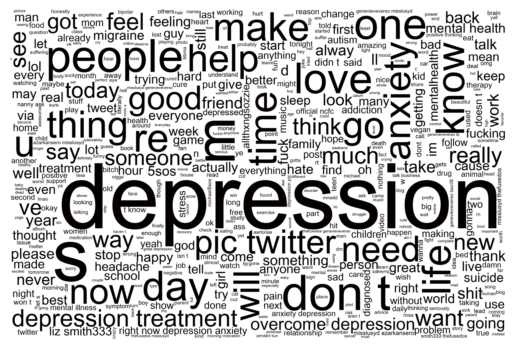

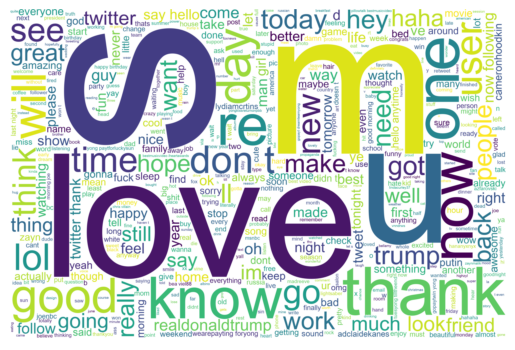

In [31]:
# change the value to black
def black_color_func(word, font_size, position, orientation, random_state=None, **kwargs):
    return("hsl(0, 100%, 1%)")

# generate 'depressed' word cloud
dep_cloud = WordCloud(font_path=r'C:\Users\chowd\Downloads\Arial Unicode MS.TTF', background_color="white", width=3000, height=2000, max_words=500).generate(' '.join(word_cloud_dep['text']))

# set the word color to black
dep_cloud.recolor(color_func=black_color_func)

plt.imshow(dep_cloud, interpolation="bilinear")
plt.axis("off")
plt.show()

# generate 'not depressed' word cloud
dep_cloud = WordCloud(font_path=r'C:\Users\chowd\Downloads\Arial Unicode MS.TTF', background_color="white", width=3000, height=2000, max_words=500).generate(' '.join(word_cloud_not_dep['text']))

plt.imshow(dep_cloud, interpolation="bilinear")
plt.axis("off")
plt.show()


In [32]:
# preprocess testing data
X_test_clean = [preprocess(text) for text in X_test]

# vectorize testing data
X_test_tfidf_vec_matrix = tfidf_vectorizer.transform(X_test_clean)

D:\nodedynamic\anaconda\lib\site-packages\bs4\__init__.py:435: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  warnings.warn(


Multinomial Naive Bayes
Accuracy: 0.8172521853867722
Precision: 0.8711918760021379
Recall: 0.6527833400080096
F1 score: 0.7463369963369964


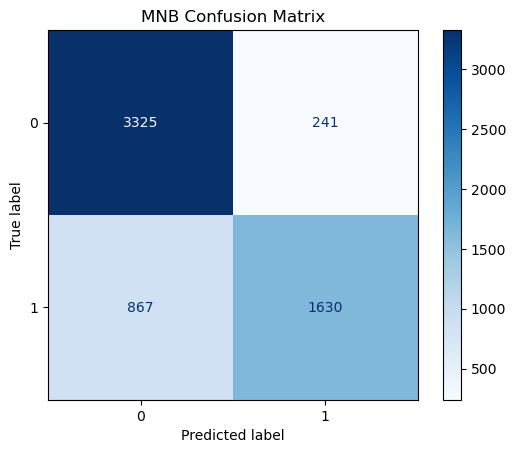

SVM
Accuracy: 0.8210456869536533
Precision: 0.8979706877113867
Recall: 0.6379655586704045
F1 score: 0.7459611332240693


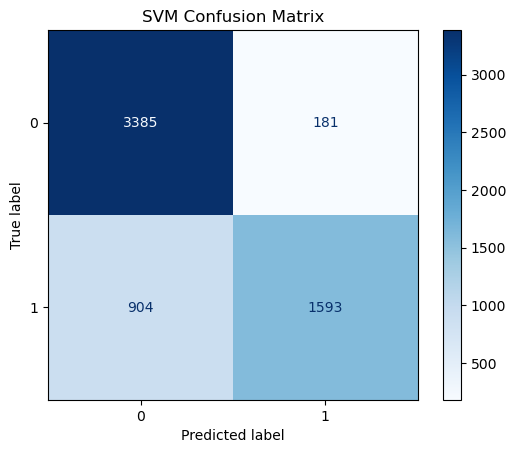

Logistic Regression
Accuracy: 0.8162625762823684
Precision: 0.8789041095890411
Recall: 0.6423708450140169
F1 score: 0.7422489588153632


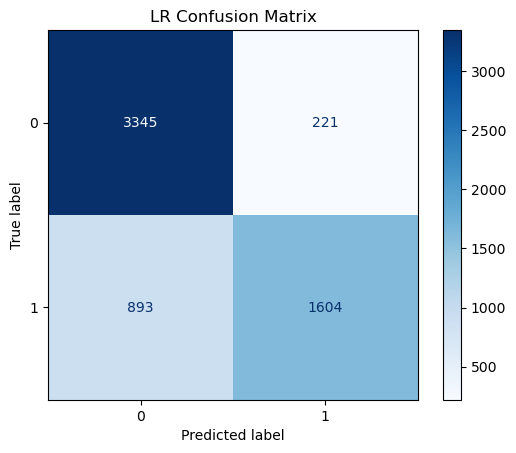

In [33]:
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.naive_bayes import MultinomialNB
from sklearn import svm
from sklearn.linear_model import LogisticRegression

# classification function to fit, predict, and evaluate performance
def classifier(clf, tfidf_vec_matrix, y_train, name, cm_title, saved_file, csv_name):
    # fit
    clf.fit(tfidf_vec_matrix, y_train)

    # predict
    y_pred = clf.predict(X_test_tfidf_vec_matrix)

    # evaluate performance
    print(name)
    print('Accuracy:', metrics.accuracy_score(y_test, y_pred))
    print('Precision:', metrics.precision_score(y_test, y_pred))
    print('Recall:', metrics.recall_score(y_test, y_pred))
    print('F1 score:', metrics.f1_score(y_test, y_pred))

    # run confusion matrix
    confusion_matrix(y_test, y_pred)

    # plot confusion matrix
    confusion = ConfusionMatrixDisplay.from_estimator(clf, X_test_tfidf_vec_matrix, y_test, cmap = plt.cm.Blues)
    confusion.ax_.set_title(cm_title)
    plt.show()

    # save model
    filename = saved_file
    pickle.dump(clf, open(filename, 'wb'))

    # save run results as csv
    row_list = [['Model', 'Accuracy', 'Precision', 'Recall', 'F1 score'],
                [name,
                 metrics.accuracy_score(y_test, y_pred),
                 metrics.precision_score(y_test, y_pred),
                 metrics.recall_score(y_test, y_pred),
                 metrics.f1_score(y_test, y_pred)]]
    
    with open(csv_name, 'w', newline='') as file:
        writer = csv.writer(file)
        writer.writerows(row_list)

# the models we want to use
mnb_clf = MultinomialNB()
lr_clf = LogisticRegression()
svm_clf = svm.SVC(kernel = 'linear')

clf_lst = [('Multinomial Naive Bayes', mnb_clf, 'MNB Confusion Matrix', 'mnb_model.sav', 'mnb_model.csv'),
           ('SVM', svm_clf, 'SVM Confusion Matrix', 'svm_model.sav', 'svm_model.csv'),
           ('Logistic Regression', lr_clf, 'LR Confusion Matrix', 'lr_model.sav', 'lr_model.csv')]

for name, clf, cm_title, saved_file, csv_name in clf_lst:
    classifier(clf, tfidf_vec_matrix, y_train, name, cm_title, saved_file, csv_name)

In [34]:
# read in saved results
saved_results = [('mnb_results', 'mnb_model.csv'), ('svm_results', 'svm_model.csv'), ('lr_results', 'lr_model.csv')]

results_dict = {}
for model, result in saved_results:
    df = pd.read_csv(result, header=0)
    results_dict[model] = df

# concatenate on new column
all_results = pd.concat(results_dict.values(), axis=0, ignore_index=True)  
print(all_results)

                     Model  Accuracy  Precision    Recall  F1 score
0  Multinomial Naive Bayes  0.817252   0.871192  0.652783  0.746337
1                      SVM  0.821046   0.897971  0.637966  0.745961
2      Logistic Regression  0.816263   0.878904  0.642371  0.742249


In [35]:
from sklearn.model_selection import GridSearchCV

# Define a function to run grid search
def run_grid_search(clf_name, clf_model, clf_grid_param):
    # Create GridSearchCV object
    grid_search = GridSearchCV(clf_model, clf_grid_param, scoring='accuracy', cv=5)

    # Fit GridSearchCV
    grid_search.fit(tfidf_vec_matrix, y_train)

    # Log hyperparameters, best parameters, and results to MLflow
    with mlflow.start_run() as run:
        # Log classifier name as a tag
        mlflow.set_tag('classifier', clf_name)
        # Log hyperparameters
        for key, value in clf_grid_param.items():
            if key not in mlflow.start_run().data.params:
                mlflow.log_param(key, value)
        # Log best parameters
        mlflow.log_params(grid_search.best_params_)
        # Log best score
        mlflow.log_metric('best_score', grid_search.best_score_)

    return grid_search

In [44]:
def clf_grid(clf_name, clf_model, clf_grid_param):
    # Create a TF-IDF vectorizer
    tfidf_vec = TfidfVectorizer()

    # Transform training data using TF-IDF vectorizer
    tfidf_vec_matrix = tfidf_vec.fit_transform(X_train)

    # Create a GridSearchCV object with specified hyperparameters and scoring metric
    grid_search = GridSearchCV(clf_model, clf_grid_param, cv=5, scoring='f1_macro')

    # Fit GridSearchCV object to training data
    grid_search.fit(tfidf_vec_matrix, y_train)

    # Log hyperparameters, best parameters, and results to MLflow
    with mlflow.start_run() as run:
        # Log classifier name as a tag
        mlflow.set_tag('classifier', clf_name)
        # Log hyperparameters
        for key, value in clf_grid_param.items():
            mlflow.log_param(key, value)
        # Log best parameters
        for key, value in grid_search.best_params_.items():
            mlflow.log_param(f"best_{key}", value)
        # Log results
        mlflow.log_metric('train_f1_macro', grid_search.best_score_)
        mlflow.log_metric('test_f1_macro', grid_search.score(tfidf_vec.transform(X_test), y_test))

    # Return best parameters and results
    return grid_search.best_params_, grid_search.best_score_, grid_search.cv_results_


In [45]:
# Define alpha values to try out
mnb_grid_param = {'alpha': [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000]}

# Create an experiment in MLflow
mlflow.set_experiment("MultinomialNB_GridSearch")

# Create an instance of MultinomialNB
mnb_clf = MultinomialNB()

# Run grid search for each classifier and hyperparameter configuration
for clf_name, clf_grid_param in mnb_grid_param.items():
    # Run grid search
    clf_grid(clf_name, mnb_clf, {'alpha': clf_grid_param})
